# Backward Euler finite difference (BEFD) 2D

C:\Users\Usuari\Anaconda3\lib\site-packages\ipykernel\__main__.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Usuari\Anaconda3\lib\site-packages\ipykernel\__main__.py:154: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Usuari\Anaconda3\lib\site-packages\ipykernel\__main__.py:160: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Usuari\Anaconda3\lib\site-packages\ipykernel\__main__.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Usuari\Anaconda3\lib\site-packages\ipykernel\__main__.py:151: ComplexWarning: Casting complex values to real discards the imaginary part


104


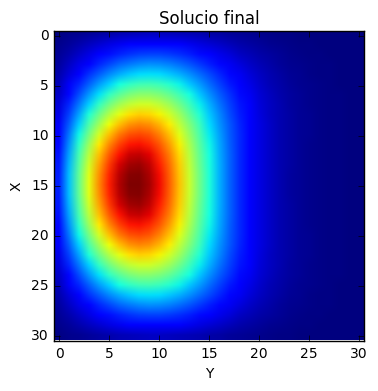

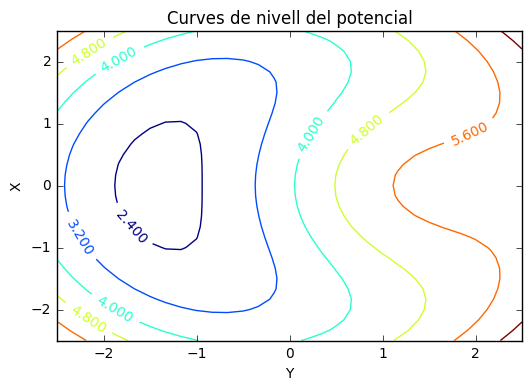

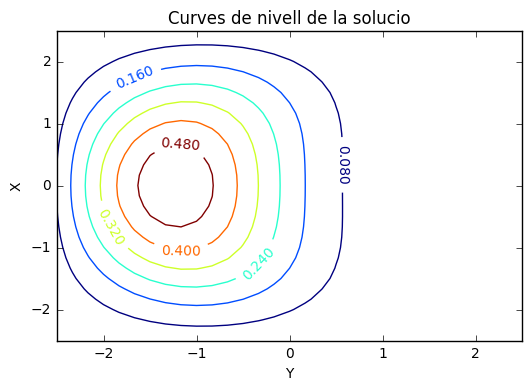

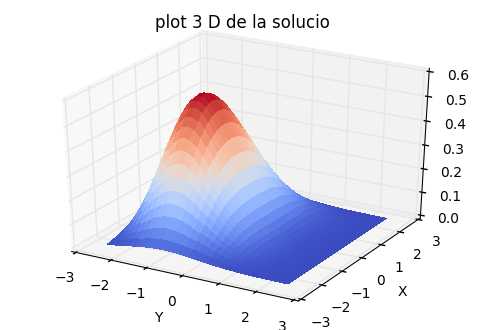

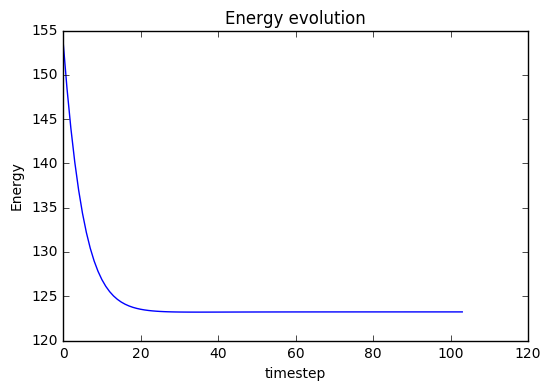

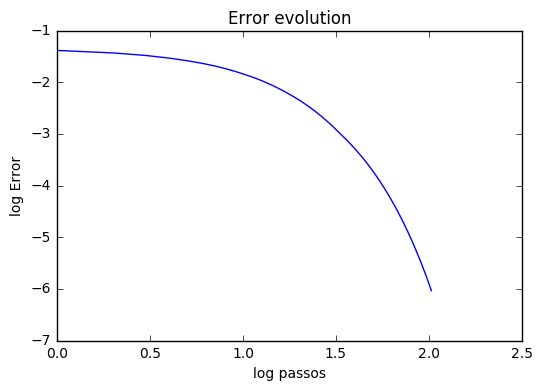

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#Per moure la camera en els plots 3D (et fa tots els plots en finestres noves)
# %matplotlib qt5 
#Per tenir els plots a la jupyter notebook (no pots girar camera en el plot 3d)
%matplotlib inline 
np.set_printoptions(precision=3) # fer que numpy nomes faci print de 3 digits significatius


## PARAMETRES---------------------------------------------------------------

#discretitzacio temporal
dt = 0.1
eps = 1e-6
#discretitzacio espaial
llargx = 5
llargy = 5
puntsx = 31
puntsy = 31
#potencial harmonic trap:
gamax = 1
gamay = 1
#potencial toroidal trap:
w0 = 5
x0 = 0
y0 = 1
d = 2
#gross-pitaevskii parameters
beta = 1 #self-interaction
sig = 0 #rotation
#subplots
freq_subplot = 0

## CODI---------------------------------------------------------------

#discretització 2D

intervalx = [-llargx/2, llargx/2]
intervaly = [-llargy/2, llargy/2]
x = np.linspace(intervalx[0],intervalx[1],num=puntsx)
dx = llargx/(puntsx-1)
y = np.linspace(intervaly[0],intervaly[1],num=puntsy)
dy = llargy/(puntsy-1)


def Volt(x,y):#s'ha d'aplicar punt per punt (no li pots entrar el vector de x i el vector de y)
    V = 0.5* (gamax**2 * x**2 + gamay**2 * y**2)+w0*np.exp(-((x-x0)**2+(y-y0)**2)/d**2)
    #V = V + w0*np.exp(-delta*((x-x0)**2+y**2)) #optical trap d'un laser
    return V
    
def sol_inicial(x,y):
    phi0 = (gamax*gamay)**(1/4)*np.pi**(-1/2)*np.exp(-0.5*(gamax*x**2 + gamay*y**2))
    return phi0

def psi_ho(x,y):
    psi_ho = 1/np.sqrt(np.pi)*np.exp(-0.5*(gamax*x**2 + gamay*y**2))
    return psi_ho
def psi_hov(x,y):
    psi_hov = (gamax*x+1j*gamay*y)/np.sqrt(np.pi)*np.exp(-0.5*(gamax*x**2 + gamay*y**2))
    return psi_hov


malla = np.zeros((len(x),len(y)))
V = malla.copy()
phi0 = malla.copy()
phi_ho = malla.copy()
phi_hov = malla.copy()
for i in range(len(x)):
    for j in range(len(y)):
        V[i][j] = Volt(x[i],y[j])
        phi0[i][j] = sol_inicial(x[i],y[j]) 
        phi_ho[i][j] = psi_ho(x[i],y[j])
        phi_hov[i][j] = psi_hov(x[i],y[j])

if sig != 0:
    phi0 = (1-sig)*phi_ho + sig*phi_hov
    norm0 = (dx*dy* np.dot(phi2,phi2))**0.5
    phi0 = phi0/norm0
               



def energy(phi):
    A = get_A(phi,1)
    for i in range(len(x)):
        for j in range(len(y)):
            A[i*len(y)+j][i*len(y)+j] = A[i*len(y)+j][i*len(y)+j] - 1 #elemino el terme identitat de get_A
    
    phi1 = np.conj(phi)
    E = np.dot(phi1,np.dot(A,phi))
    return E

'''
#FALTA DEFINIR L'ENERGIA
#CANVIAR LA DEFINICIO
def energy(phi2): # phi2 no té els índexs 0 i M
    E = dx * np.sum(V[1:-1]*abs(phi2)**2+ 0.5*beta*abs(phi2)**4)
    phipos = np.append(phi2,0)
    phineg = np.append(0,phi2)
    E = E + 1/dx * np.sum(abs(phipos-phineg)**2)
    return E
'''

# METODE NUMERIC---------------------------------------------------------------
error = 1e4
#la funcio d'ona s'anul·la a la vora en x = -1, len(x) | y = -1, len(y)

#S'HA DE VECTORITZAR LES COSES QUE ESTAN EN 2D
phi = phi0.flatten()

def get_A(phi,dt):

    B = np.zeros([len(phi),len(phi)])

    for i in range(len(x)):
        for j in range(len(y)):
            '''
            1D:  A = np.eye(punts-2) + dt* np.diag(V[1:-1]) + beta* dt* np.diag(abs(phi))**2 
            Sense vectoritzar (4D)
            A = np.zeros([len(x),len(y),len(x),len(y)])
            A[i,j,i,j] = A[i,j,i,j] + 1 +dt*V[i,j] + beta*dt*abs(phi[i,j])**2 
            '''
            #Vectoritzat
            B[i*len(y)+j][i*len(y)+j] = B[i*len(y)+j][i*len(y)+j] + 1 +dt*V[i,j] + beta*dt*abs(phi[i*len(y)+j])**2 


            #LAPLACIA
            #1D:  A = A -(0.5*dt/dx**2)*(np.diag(-2*np.ones(punts-2))+ np.diag(1*np.ones(punts-3),-1) +np.diag(1*np.ones(punts-3),1))
            #4D: A[i,j,i,j] = A[i,j,i,j] -0.5*dt*(-2/dx**2 -2/dy**2)

            B[i*len(y)+j][i*len(y)+j] = B[i*len(y)+j][i*len(y)+j] -0.5*dt*(-2/dx**2 -2/dy**2)
            if i > 0:
                #4D: A[i,j,i-1,j] = A[i,j,i-1,j] -0.5*dt*(1/dx**2)
                B[i*len(y)+j][(i-1)*len(y)+j] = B[i*len(y)+j][(i-1)*len(y)+j] -0.5*dt*(1/dx**2)
            if i < len(x)-1:
                #4D: A[i,j,i+1,j] = A[i+1,j,i+1,j] -0.5*dt*(1/dx**2)
                B[i*len(y)+j][(i+1)*len(y)+j] = B[i*len(y)+j][(i+1)*len(y)+j] -0.5*dt*(1/dx**2)
            if j > 0:
                #4D: A[i,j,i,j-1] = A[i,j,i,j-1] -0.5*dt*(1/dy**2)
                B[i*len(y)+j][i*len(y)+j-1] = B[i*len(y)+j][i*len(y)+j-1] -0.5*dt*(1/dy**2)
            if j < len(y)-1:
                #4D: A[i,j,i,j+1] = A[i,j,i,j+1] -0.5*dt*(1/dy**2)
                B[i*len(y)+j][i*len(y)+j+1] = B[i*len(y)+j][i*len(y)+j+1] -0.5*dt*(1/dy**2)

            
            #moment angular
            if i > 0:
                #4D: A[i,j,i-1,j] = A[i,j,i-1,j] -sig*dt*(1j*y[j])*(-1/(2*dx))
                B[i*len(y)+j][(i-1)*len(y)+j] = B[i*len(y)+j][(i-1)*len(y)+j] -sig*dt*(1j*y[j])*(-1/(2*dx))
            if i < len(x)-1:
                #4D: A[i,j,i+1,j] = A[i+1,j,i+1,j] -sig*dt*(1j*y[j])*(1/(2*dx))
                B[i*len(y)+j][(i+1)*len(y)+j] = B[i*len(y)+j][(i+1)*len(y)+j] -sig*dt*(1j*y[j])*(1/(2*dx))
            if j > 0:
                #4D: A[i,j,i,j-1] = A[i,j,i,j-1] -sig*dt*(-1j*x[i])*(-1/(2*dy))
                B[i*len(y)+j][i*len(y)+j-1] = B[i*len(y)+j][i*len(y)+j-1]  -sig*dt*(-1j*x[i])*(-1/(2*dy))
            if j < len(y)-1:
                #4D: A[i,j,i,j+1] = A[i,j,i,j+1] -sig*dt*(-1j*x[i])*(1/(2*dy))
                B[i*len(y)+j][i*len(y)+j+1] = B[i*len(y)+j][i*len(y)+j+1] -sig*dt*(-1j*x[i])*(1/(2*dy))
            
    return B
        


pas = 0
Evec = []
errorvec = []
while(error > eps): #als papers crec que imposen > eps*dt
    A = get_A(phi,dt)
    phi2 = np.linalg.solve(A,phi)
    norm = (dx*dy* np.dot(phi2,phi2))**0.5
    phi2 = phi2/norm
    error = np.max(np.abs(phi2-phi))
    phi = phi2
    
    if freq_subplot != 0 and pas%freq_subplot == 0:
        print(pas)
        plt.imshow(abs(phi.reshape(len(x),len(y))))
        plt.ylabel('X')
        plt.xlabel('Y')
        plt.show()
    if pas%1 == 0: #guardem les energies cada 100 passos
        E = energy(phi2)
        Evec = Evec + [E]
        errorvec = errorvec + [np.log10(error)]
    pas += 1

sol = phi.reshape(len(x),len(y))

#PLOTS---------------------------------------------------------------

print(pas)
#colorplot de la condicio inicial
# plt.imshow(phi0)
# plt.show()

#colorplot de la solucio
fig, ax = plt.subplots()
ax.imshow(sol)
ax.set_title('Solucio final')
plt.ylabel('X')
plt.xlabel('Y')
plt.show()

#plot de les curves de nivell del potencial
fig, ax = plt.subplots()
X,Y = np.meshgrid(x,y)
CS = ax.contour(X, Y, V)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Curves de nivell del potencial')
plt.ylabel('X')
plt.xlabel('Y')
plt.plot()

#plot de les curves de nivell de la solucio
fig, ax = plt.subplots()
X,Y = np.meshgrid(x,y)
CS = ax.contour(X, Y, sol)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Curves de nivell de la solucio')
plt.ylabel('X')
plt.xlabel('Y')
plt.plot()



#plot 3d de la solucio
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
X,Y = np.meshgrid(x,y)
ha.plot_surface(X, Y, sol, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
# ha.contour(X,Y,sol, levels=levels)
ha.set_title('plot 3 D de la solucio')
plt.ylabel('X')
plt.xlabel('Y')
plt.show()

#plot de l'energia segons timestep
fig, ax = plt.subplots()
pasvec = np.arange(0,pas,1)
ax.plot(pasvec,Evec)
ax.set_title('Energy evolution')
plt.ylabel('Energy')
plt.xlabel('timestep')
plt.show()

#plot de l'error segons log(timestep)
fig, ax = plt.subplots()
pasvec[0] += 1
pasvec2 = np.log10(pasvec)
ax.plot(pasvec2,errorvec)
ax.set_title('Error evolution')
plt.ylabel('log Error')
plt.xlabel('log passos')
plt.show()




In [ ]:
#revisar moment angular ( és normal que rotating colapsi cap un costat?)
#trobar vortexs